In [ ]:
pip install yfinance ta scikit-learn matplotlib pandas numpy


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.83       101
           1       0.00      0.00      0.00         0

    accuracy                           0.70       101
   macro avg       0.50      0.35      0.41       101
weighted avg       1.00      0.70      0.83       101

Accuracy: 0.7029702970297029


/Users/hemank/Documents/github/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/hemank/Documents/github/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/hemank/Documents/github/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

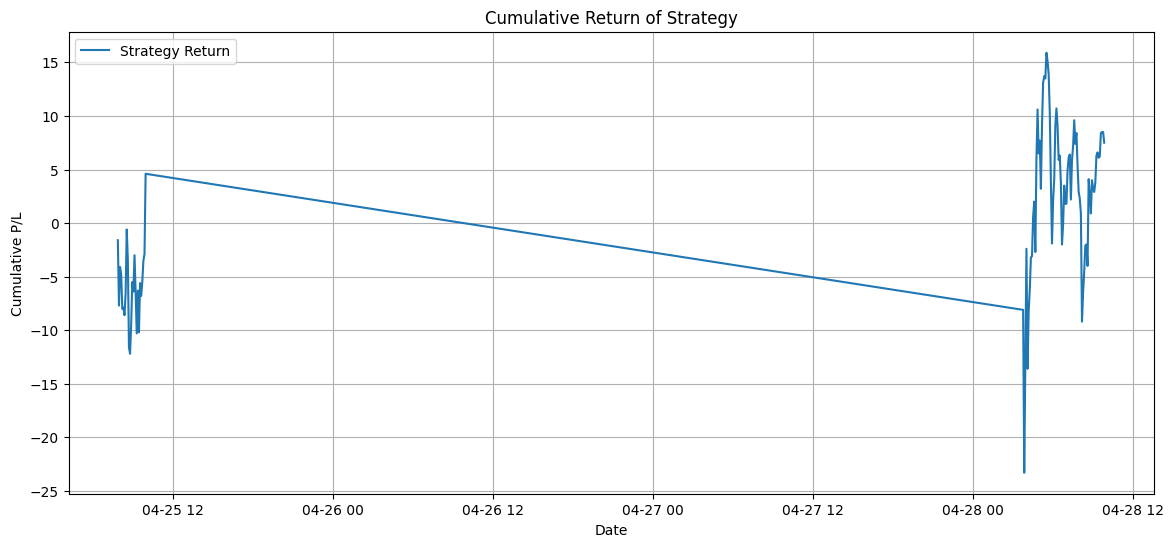

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Parameters
ticker = "TCS.NS"  # Change to your desired ticker
interval = "1m"
period = "60d"
future_minutes = 390 * 5  # 1 week = 5 trading days * 390 minutes/day

# Step 1: Download data
df = yf.download(ticker, period=period, interval=interval, progress=False)
df = df.dropna()
df.reset_index(inplace=True)
df.columns = [col.lower().replace(" ", "_") for col in df.columns]

# Step 2: Feature Engineering
df['sma_20'] = ta.trend.sma_indicator(df['close'], window=20)
df['sma_50'] = ta.trend.sma_indicator(df['close'], window=50)
df['rsi'] = ta.momentum.rsi(df['close'], window=14)
df['macd'] = ta.trend.macd_diff(df['close'])
df['volatility'] = ta.volatility.bollinger_hband(df['close']) - ta.volatility.bollinger_lband(df['close'])
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['dayofweek'] = df['datetime'].dt.dayofweek
df.dropna(inplace=True)

# Step 3: Labeling for Classification
df['future_close'] = df['close'].shift(-future_minutes)
df['target'] = np.where(df['future_close'] > df['close'], 1, 0)  # 1 = up, 0 = down
df.dropna(inplace=True)

# Step 4: Train-Test Split
features = ['sma_20', 'sma_50', 'rsi', 'macd', 'volatility', 'hour', 'minute', 'dayofweek']
X = df[features]
y = df['target']
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
df_test = df.iloc[split_index:]

# Step 5: Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Prediction
y_pred = model.predict(X_test)
df_test['prediction'] = y_pred

# Step 7: Backtest Simulation
df_test['strategy_return'] = np.where(df_test['prediction'] == 1,
                                      df_test['close'].shift(-1) - df_test['close'],
                                      df_test['close'] - df_test['close'].shift(-1))
df_test['cumulative_return'] = df_test['strategy_return'].cumsum()

# Step 8: Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_test['datetime'], df_test['cumulative_return'], label='Strategy Return')
plt.title("Cumulative Return of Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative P/L")
plt.legend()
plt.grid()
plt.show()